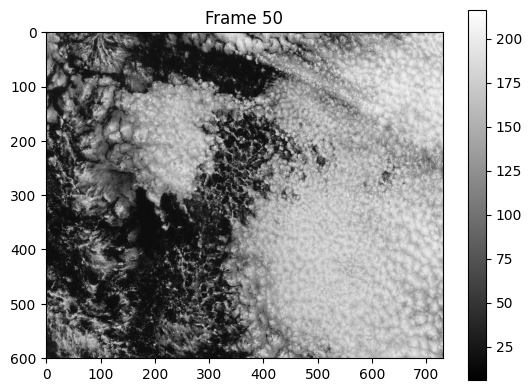

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Read the video using OpenCV
#cap = cv2.VideoCapture("DATA/syn_scwave_warp_modx5.mp4")
cap = cv2.VideoCapture("DATA/closedcellday_2022_09_06.mp4")
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        break

cap.release()

# Convert frames to a NumPy array
video = np.stack(frames, axis=0)  # Shape: (num_frames, height, width, 3)

# Rearrange dimensions to match MATLAB's (height, width, color, num_frames)
video = np.transpose(video, (1, 2, 3, 0))  # Shape: (height, width, 3, num_frames)

# Extract the red channel (OpenCV uses BGR format)
red = video[:, :, 2, :]  # Shape: (height, width, num_frames)

# SELECT ONE FRAME FOR SPATIAL ANALYSIS
# Adjust indices for Python (0-based indexing)
frame50 = red[99:700, 149:880, 2]  # Selecting the 3rd frame (index 2)

# QUICK SHOW
plt.figure(1)
plt.imshow(frame50, cmap='gray')
plt.colorbar()
plt.title('Frame 50')
plt.show()

# Convert frame50 to MATLAB double
frame50_matlab = matlab.double(frame50.tolist())

In [20]:
# Define wavelet parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]
wavelet_struct = {'name': wavelet_name, 'param': params}
scales = 10 ** np.arange(1, 1.95, 0.05) 
scales_matlab = matlab.double(scales.tolist())
scales_km = (4 * np.pi * scales) / (params[0] + np.sqrt(2 + params[0]**2)) * 2  # Convert scales to km
angles = [0, np.pi/8 ,np.pi/4, 3*np.pi/8 ,np.pi/2, 5*np.pi/8 ,3*np.pi/4, 7*np.pi/8 ,np.pi]  
angles_matlab = matlab.double(angles)

# Perform 2D CWT on both images
spec= eng.cwtft2(frame50_matlab, 'wavelet', wavelet_struct, 'scales', scales_matlab, 'angles', angles_matlab)['cfs']

TypeError: 'NoneType' object is not subscriptable

Shape of spec before squeeze: (601, 731, 19, 9)
Shape of spec after squeeze: (601, 731, 19, 9)


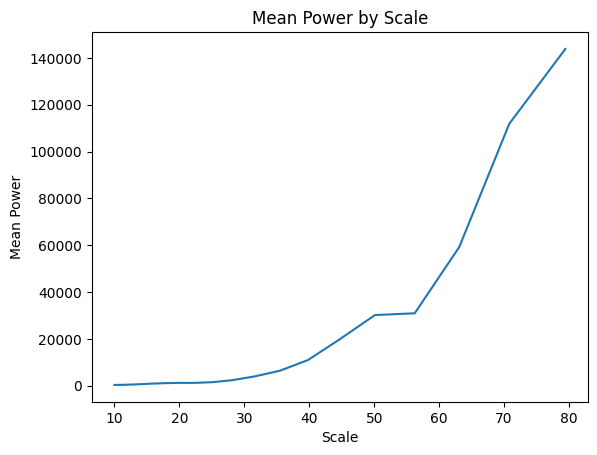

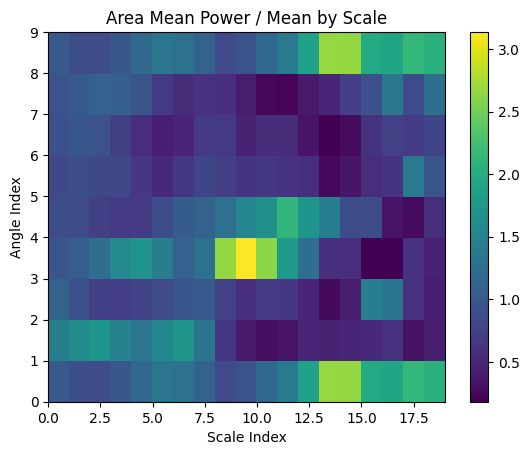

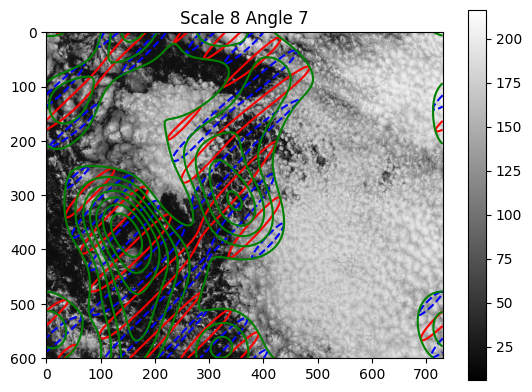

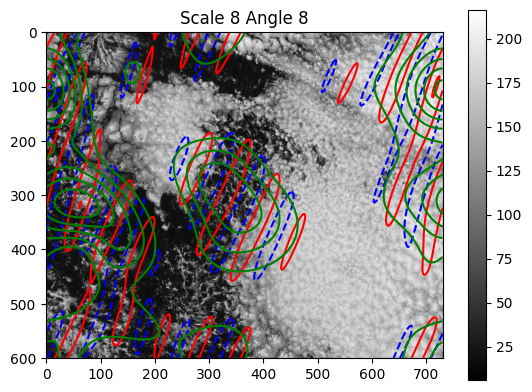

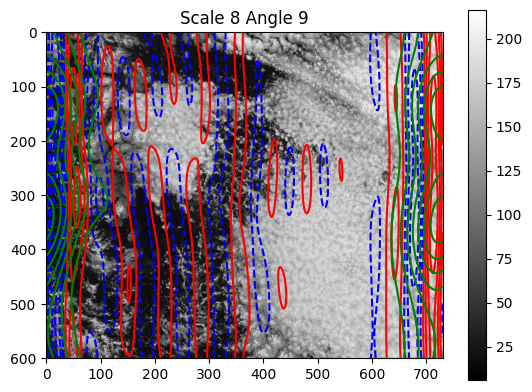

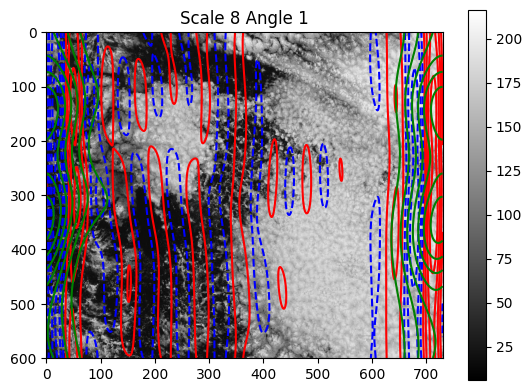

In [ ]:
# Convert MATLAB array to NumPy array
spec = np.asarray(spec, dtype=np.complex_)
print('Shape of spec before squeeze:', spec.shape)  # (601, 731, 1, 19, 9)

# Remove singleton dimension
spec = np.squeeze(spec)  # Shape becomes (601, 731, 19, 9)
print('Shape of spec after squeeze:', spec.shape)

# Compute power spectrum
power = np.abs(spec) ** 2

# Compute area-averaged power by angle and scale
inner_power = np.mean(np.mean(power[99:500, 99:600, :, :], axis=0), axis=0)  # Shape: (19, 9)

# Compute mean power by scale (mean over angles)
mean_by_scale = np.mean(inner_power, axis=1)  # Shape: (19,)

# Plot mean power by scale
plt.figure(2)
plt.plot(scales, mean_by_scale)
plt.title('Mean Power by Scale')
plt.xlabel('Scale')
plt.ylabel('Mean Power')
plt.show()

# Normalize power by mean increase with scale
anglespec = inner_power / mean_by_scale[:, np.newaxis]  # Shape: (19, 9)

# Plot the angle spectrum
plt.figure(3)
plt.pcolor(anglespec.T)
plt.colorbar()
plt.title('Area Mean Power / Mean by Scale')
plt.xlabel('Scale Index')
plt.ylabel('Angle Index')
plt.show()

# Function to overlay wavelet power on image
def image_with_wavelet_overlay(img, spec, Scales, scale_idx, angle_idx):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.axis('on')

    pos_levels = np.arange(1, 10, 2)
    neg_levels = np.arange(-9, 0, 2)

    factor = Scales[scale_idx]

    # Real part contours
    plt.contour(np.real(spec[:, :, scale_idx, angle_idx]),
                levels=pos_levels * factor, colors='red')
    plt.contour(np.real(spec[:, :, scale_idx, angle_idx]),
                levels=neg_levels * factor, colors='blue')

    # Power contours
    plt.contour((np.abs(spec[:, :, scale_idx, angle_idx]) * factor) ** 2,
                colors='green')

    plt.title(f'Scale {scale_idx+1} Angle {angle_idx+1}')
    plt.show()

# Example usage
image_with_wavelet_overlay(frame50, spec, scales, 7, 6)
image_with_wavelet_overlay(frame50, spec, scales, 7, 7)
image_with_wavelet_overlay(frame50, spec, scales, 7, 8)
image_with_wavelet_overlay(frame50, spec, scales, 7, 0)  # Adjusted angle index